In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded
import seaborn as sns 

sns.set()

### Постановка задачи

$$
u_t = u_{xx} + b u
$$
$$
u(t, 0) = u(t, 1) = 0
$$
$$
u(t = 0, x) = \sin \pi x
$$
Решение:
$$
u(t, x) = \exp \{- t (\pi ^2 - b)\} \sin \pi x
$$


Видно, что при $b > \pi^2$ решение становится экспоненциально возрастающим. Как можно с этим бороться? Поставим другую задачу:

$$
v _t = v _{xx} + b v
$$
$$
v(t, 0) = 0, \quad v(t, 1) = \mu (t)
$$
$$
v(0, x) = \sin \pi x
$$
Управляя $\mu$, хотим получить:
$$
||v(t)|| \rightarrow 0
$$

Не до конца ясно, как её решать, перейдем к более понятному сетапу:

$$
w _t = w _{xx} + b w
$$
$$
w(t, 0) = 0, \quad w(t, 2) = 0
$$
$$
w(0, x) = \sin \pi x \text{ (при $x \leq 1$)}
$$
$$
w(0, x) = ? \text{ (при $1 < x \leq 2$)}
$$

$$
w(t, x) = \sum _{k=1} ^{\infty} c_k(t) \sin \frac{\pi k x}{2}
$$

Выбираем ? так, чтобы загасить плохие коэффициенты в решении (которые устремляются к бесконечности).

? ищем в виде:

? = $c_1 l_1 + c_2 l_2$

$$
l_1(0, x) = 0 \text{ (при $x \leq 1$)}
$$
$$
l_1(0, x) = \sin \frac{\pi x}{2}  \text{ (при $1 < x \leq 2$)}
$$
$$
l_2(0, x) = 0 \text{ (при $x \leq 1$)}
$$
$$
l_2(0, x) = \sin \pi x  \text{ (при $1 < x \leq 2$)}
$$

$$
c_1, \ c_2: (w(x), \sin \frac{\pi x}{2}) = 0 \quad (w(x), \sin \pi x) = 0 
$$

### Решалка УрЧП

Рассматривать будем неявную схему:

$$
\frac{u _m ^{n + 1} - u^n _{m}}{\tau} = \frac{u^{n + 1} _ {m + 1} - 2 u ^{n + 1} _m + u^{n + 1} _{m - 1}}{h^2} + 10 u ^{n + 1} _m
$$

Ей соответствует матрица:

$$
\begin{pmatrix}
1 + \frac{2 \tau}{h^2} - b \tau & - \frac{\tau}{h^2} & 0 & \cdots & 0 & 0 \\
- \frac{\tau}{h^2} & 1 + \frac{2 \tau}{h^2} - b \tau & - \frac{\tau}{h^2} & \cdots & 0 & 0 \\
0 & - \frac{\tau}{h^2} & 1 + \frac{2 \tau}{h^2} - b \tau & - \frac{\tau}{h^2} & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & \cdots & 0 & - \frac{\tau}{h^2} & 1 + \frac{2 \tau}{h^2} - b \tau & - \frac{\tau}{h^2} \\
0 & 0 & \cdots & 0 & - \frac{\tau}{h^2} & 1 + \frac{2 \tau}{h^2} - b \tau \\
\end{pmatrix}
$$.

Теперь добавим граничные условия. 
$$
u^0_m = u_{\text{left}} (x_m)
$$
$$
u^N_m = u_{\text{right}} (x_m)
$$
Эти условия явно подставим в первое и последнее уравнение системы и перенесем в левую часть, получим систему:
$$
\begin{pmatrix}
1 + \frac{2 \tau}{h^2} - b \tau & - \frac{\tau}{h^2} & 0 & \cdots & 0 & 0 \\
- \frac{\tau}{h^2} & 1 + \frac{2 \tau}{h^2} - b \tau & - \frac{\tau}{h^2} & \cdots & 0 & 0 \\
0 & - \frac{\tau}{h^2} & 1 + \frac{2 \tau}{h^2} - b \tau & - \frac{\tau}{h^2} & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & \cdots & 0 & - \frac{\tau}{h^2} & 1 + \frac{2 \tau}{h^2} - b \tau & - \frac{\tau}{h^2} \\
0 & \cdots & 0 & 0 & - \frac{\tau}{h^2} & 1 + \frac{2 \tau}{h^2} - b \tau \\
\end{pmatrix}
\begin{pmatrix}
u_{m+1}^1 \\
u_{m+1}^2 \\
u_{m+1}^3 \\
\vdots \\
u_{m+1}^{N-2} \\
u_{m+1}^{N-1} \\
\end{pmatrix} =
\begin{pmatrix}
u_{m}^1 + \frac{\tau}{h^2} u^0_{m+1} \\
u_{m}^2 \\
u_{m}^3 \\
\vdots \\
u_{m}^{N-2} \\
u_{m}^{N-1} + \frac{\tau}{h^2} u^N_{m+1}\\
\end{pmatrix}
$$.

In [3]:
def solve_parabolic_implicit(u0_func, u_left, u_right, L=1.0, N=50, b=1.0, T=0.1, dt=0.001):
    """
    Решение уравнения u_t = u_{xx} + b u на отрезке [0, L] с граничными условиями
    u(0,t) = u_left(t), u(L,t) = u_right(t) и начальным условием u(x,0) = u0_func(x)
    при помощи неявной разностной схемы.
    
    Параметры:
    ----------
    u0_func : callable
        Функция начального условия, u0_func(x).
    u_left : callable
        Функция, задающая граничное условие на левом конце: u_left(t).
    u_right : callable
        Функция, задающая граничное условие на правом конце: u_right(t).
    L : float
        Длина отрезка расчёта по оси x.
    N : int
        Число узлов сетки по пространству (включая граничные точки).
    b : float
        Коэффициент при u в уравнении.
    T : float
        Конечное время расчёта.
    dt : float
        Шаг по времени.
    
    Возвращает:
    -----------
    x : ndarray
        Сетка по пространству.
    u_all : list of ndarray
        Список массивов решения в различные моменты времени (включая начальное).
        Первый элемент соответствует t=0, последний - t=T.
    """
    h = L/(N-1)
    x = np.linspace(0, L, N)

    nt = int(T/dt)

    u = np.array([u0_func(xi) for xi in x], dtype=float)
    
    u[0] = u_left(0.0)
    u[-1] = u_right(0.0)

    mu = dt/h**2

    main_diag = (1 + 2*mu + dt*b)*np.ones(N-2)
    off_diag = -mu * np.ones(N-3)

    ab = np.zeros((3, N-2))
    ab[0,1:] = off_diag     
    ab[1,:] = main_diag     
    ab[2,:-1] = off_diag    

    u_all = [u.copy()]

    for n in range(nt):
        t_new = (n+1)*dt

        left_val = u_left(t_new)
        right_val = u_right(t_new)

        rhs = u[1:-1].copy()

        rhs[0] += mu * left_val
        rhs[-1] += mu * right_val

        u_inner = solve_banded((1,1), ab, rhs)

        u[1:-1] = u_inner
        u[0] = left_val
        u[-1] = right_val

        u_all.append(u.copy())

    return x, u_all


### Тест решалки

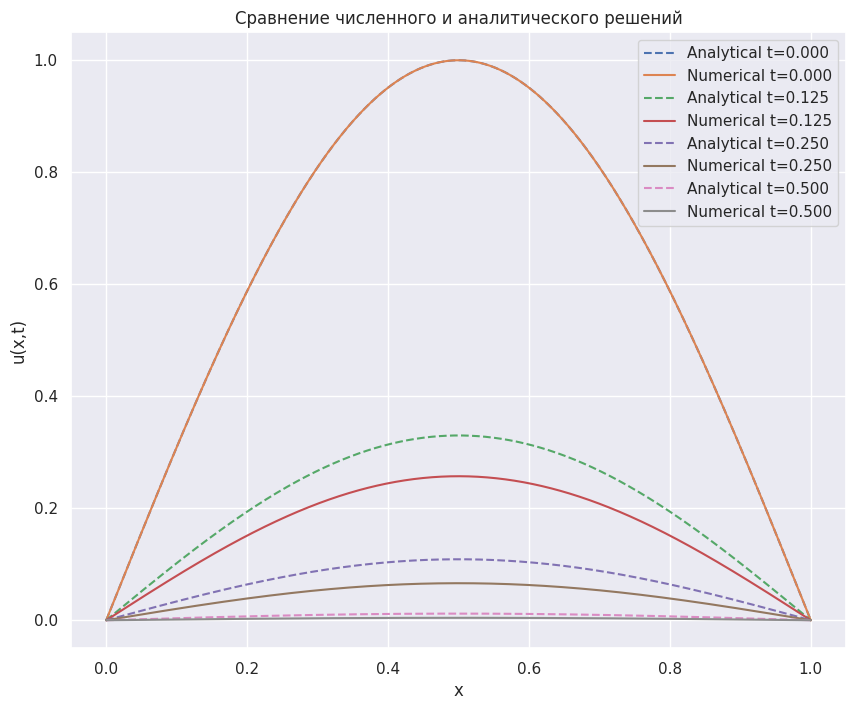

In [7]:
u0 = lambda x: np.sin(np.pi * x) 

u_left = lambda t: 0.0 
u_right = lambda t: 0.0

L = 1.0
N = 1000
b = 1.0
T = 0.5
dt = 0.0001

x, solutions = solve_parabolic_implicit(u0, u_left, u_right, L, N, b, T, dt)

steps_to_plot = [0, len(solutions)//4, len(solutions)//2, len(solutions)-1]

u_analytical = lambda t, x: np.exp(-t * (np.pi**2 - b)) * np.sin(np.pi * x)

plt.figure(figsize=(10, 8))

for i in steps_to_plot:
    t = i * dt
    u_analyt = u_analytical(t, x)
    plt.plot(x, u_analyt, '--', label=f'Analytical t={t:.3f}')
    plt.plot(x, solutions[i], label=f'Numerical t={t:.3f}')

plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Сравнение численного и аналитического решений')
plt.grid(True)
plt.legend()
plt.show()

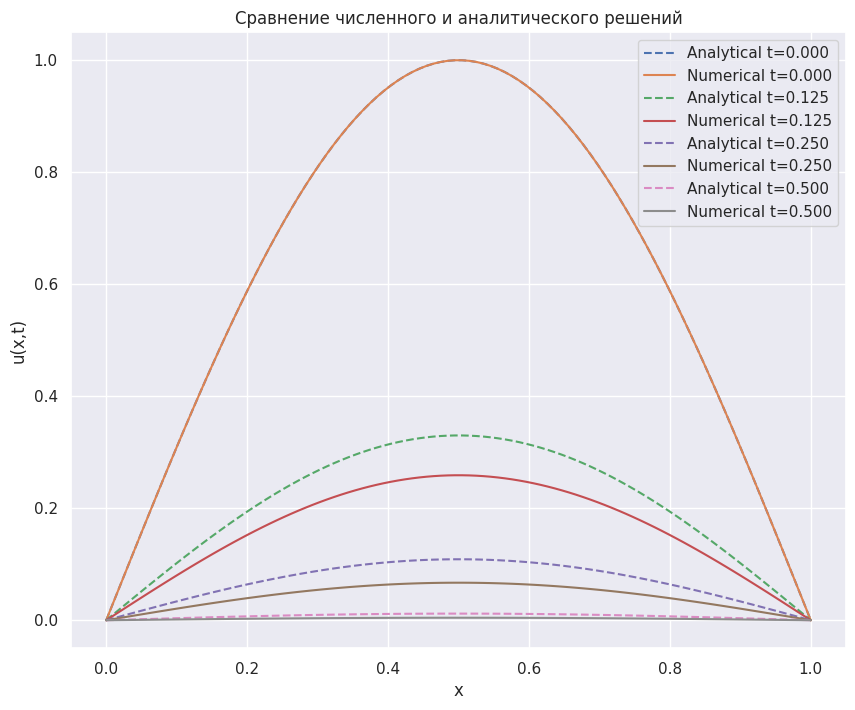

In [8]:
u0 = lambda x: np.sin(np.pi * x) 

u_left = lambda t: 0.0 
u_right = lambda t: 0.0

L = 1.0
N = 100
b = 1.0
T = 0.5
dt = 0.001

x, solutions = solve_parabolic_implicit(u0, u_left, u_right, L, N, b, T, dt)

steps_to_plot = [0, len(solutions)//4, len(solutions)//2, len(solutions)-1]

u_analytical = lambda t, x: np.exp(-t * (np.pi**2 - b)) * np.sin(np.pi * x)

plt.figure(figsize=(10, 8))

for i in steps_to_plot:
    t = i * dt
    u_analyt = u_analytical(t, x)
    plt.plot(x, u_analyt, '--', label=f'Analytical t={t:.3f}')
    plt.plot(x, solutions[i], label=f'Numerical t={t:.3f}')

plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Сравнение численного и аналитического решений')
plt.grid(True)
plt.legend()
plt.show()

### Случай возрастающих решений

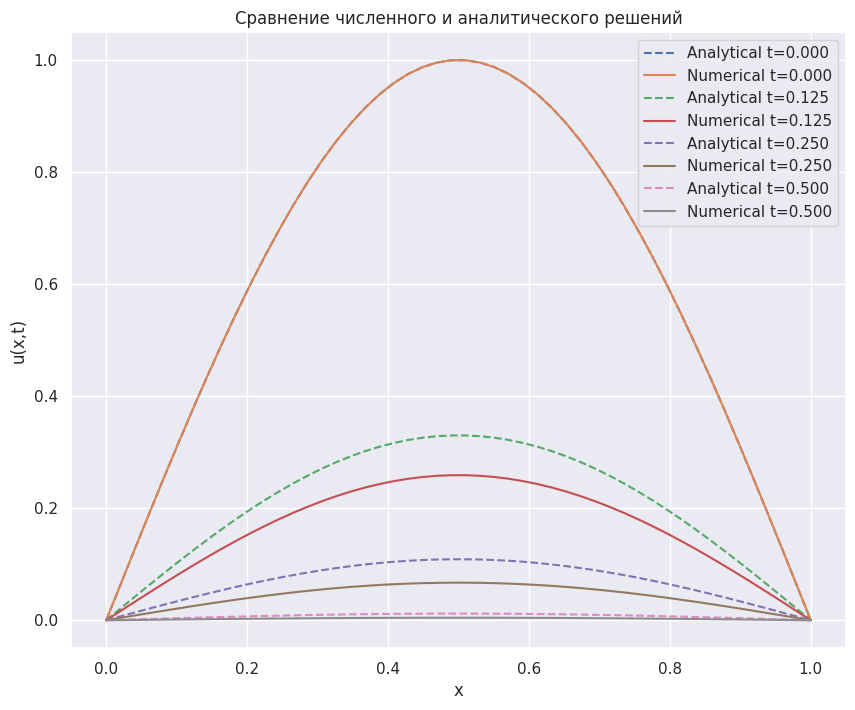

In [5]:
u0 = lambda x: np.sin(np.pi * x) 

u_left = lambda t: 0.0 
u_right = lambda t: 0.0

L = 1.0
N = 50
b = 1.0
T = 0.5
dt = 0.001

x, solutions = solve_parabolic_implicit(u0, u_left, u_right, L, N, b, T, dt)

steps_to_plot = [0, len(solutions)//4, len(solutions)//2, len(solutions)-1]

u_analytical = lambda t, x: np.exp(-t * (np.pi**2 - b)) * np.sin(np.pi * x)

plt.figure(figsize=(10, 8))

for i in steps_to_plot:
    t = i * dt
    u_analyt = u_analytical(t, x)
    plt.plot(x, u_analyt, '--', label=f'Analytical t={t:.3f}')
    plt.plot(x, solutions[i], label=f'Numerical t={t:.3f}')

plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Сравнение численного и аналитического решений')
plt.grid(True)
plt.legend()
plt.show()

Видно, что всё пошло не по плану. Попробуем вычислить добавку, "убивающую" возрастающие члены.
$$
c_1, \ c_2: (w(x), \sin \frac{\pi x}{2}) = 0 \quad (w(x), \sin \pi x) = 0 
$$
Это превращается в систему:
$$
\begin{cases}
  \int _0^1 \sin \pi x \sin \frac{\pi x}{2} dx + c_1 \int _1^2 \sin \frac{\pi x}{2} \sin \frac{\pi x}{2} dx + c_2 \int _1^2 \sin \pi x \sin \frac{\pi x}{2} dx = 0,   \\
  \int _0^1 \sin \pi x \sin \pi x dx + c_1 \int _1^2 \sin \frac{\pi x}{2} \sin \pi x dx + c_2 \int _1^2 \sin \pi x \sin \pi x dx = 0.
\end{cases}
$$

$$
\int _0^1 \sin \pi x \sin \pi x dx = \frac{1}{2}
$$
$$
\int _0^1 \sin \pi x \sin \frac{\pi x}{2} dx = \frac{4}{3\pi}
$$
$$
\int _1^2 \sin \frac{\pi x}{2} \sin \frac{\pi x}{2} dx = \frac{1}{2}
$$
$$
\int _1^2 \sin \pi x \sin \frac{\pi x}{2} dx = -\frac{4}{3\pi}
$$
$$
\int _1^2 \sin \pi x \sin \pi x dx = \frac{1}{2}
$$

Подставив интегралы в систему, получим:
$$
\begin{cases}
    \frac{4}{3\pi} + c_1 \cdot \frac{1}{2} - c_2 \cdot \frac{4}{3\pi} = 0, \\
    \frac{1}{2} - c_1 \cdot \frac{4}{3\pi} + c_2 \cdot \frac{1}{2} = 0.
\end{cases}
$$

Итого, имеем:
$$
c_1 = - \frac{48 \pi}{9 \pi^2 - 64}, \quad c_2 = - \frac{9 \pi^2 + 64}{9 \pi^2 - 64}
$$

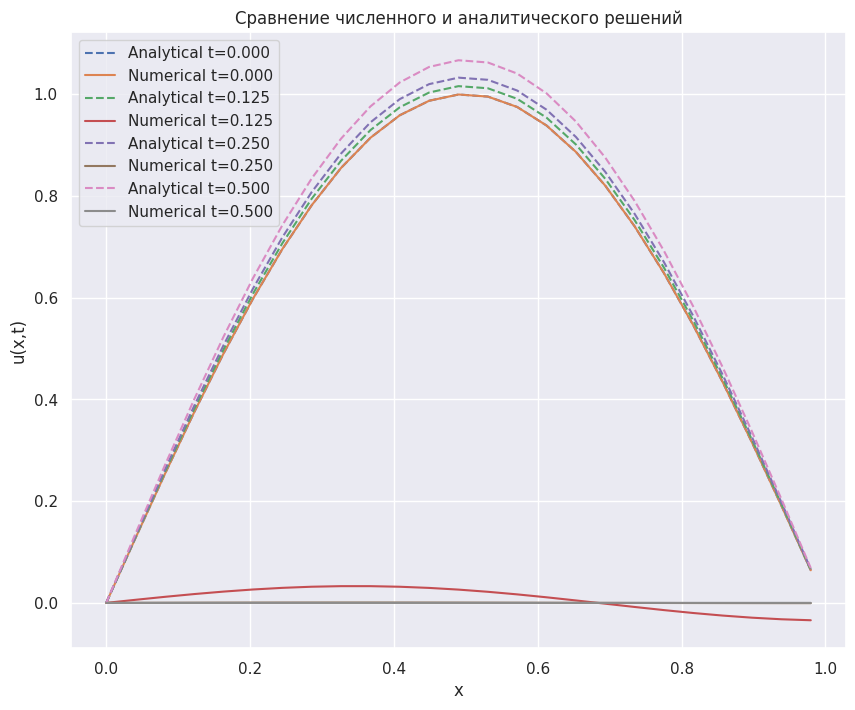

In [6]:
def u0(x):
    c1 = - 48 * np.pi / (9 * np.pi**2 - 64)
    c2 = -(9 * np.pi**2 + 64) / (9 * np.pi**2 - 64) 
    if x <= 1:
        return np.sin(np.pi * x)
    else:
        return c1 * np.sin(np.pi * x * 0.5) + c2 * np.sin(np.pi * x)


u0 = np.vectorize(u0)

u_left = lambda t: 0.0 
u_right = lambda t: 0.0

L = 2.0
N = 50
b = 10.0
T = 0.5
dt = 0.001

x, solutions = solve_parabolic_implicit(u0, u_left, u_right, L, N, b, T, dt)
x = x[:int(len(x) / 2)]

steps_to_plot = [0, len(solutions)//4, len(solutions)//2, len(solutions)-1]

u_analytical = lambda t, x: np.exp(-t * (np.pi**2 - b)) * np.sin(np.pi * x)

plt.figure(figsize=(10, 8))

for i in steps_to_plot:
    t = i * dt
    u_analyt = u_analytical(t, x)
    plt.plot(x, u_analyt, '--', label=f'Analytical t={t:.3f}')
    plt.plot(x, solutions[i][:len(x)], label=f'Numerical t={t:.3f}')

plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Сравнение численного и аналитического решений')
plt.grid(True)
plt.legend()
plt.show()